# Learning to Dynamically Decouple
### Smart Dynamic Decoupling system that optimizes for your circuit



## What is Dynamical Decoupling?
Dynamical Decoupling (DD) is an error suppression technique that combats decoherence by actively flipping qubits during idle periods.
These flips — typically π rotations (e.g. X or Y gates) — cause noise effects to cancel out over time, preserving the quantum information longer.
It’s like periodically “shaking off” unwanted interactions with the environment.

Standard DD uses fixed sequences like:

- CPMG (X–X)

- XY4, XY8

- Uhrig DD (non-uniform spacing)

These are general-purpose but not tailored to your specific quantum circuit or hardware. Dynamic Decoupling could be made very specific for the hardware, but it assumes we know the interactions of the circuit with the environment. We can optimize the circuit by learning the parameters from the circuit, calcuting the cost function.

## Why learning it matters?
Every quantum circuit interacts with noise in a unique way depending on:

- Its structure (which qubits are idle and when)

- The backend (gate times, coherence times, noise model)

Traditional DD sequences ignore this.
But Learning Dynamical Decoupling (LDD):

- Optimizes pulse timing and phases for your specific circuit

- Learns parameters that suppress real decoherence

- Exploits hardware-specific capabilities (pulse-level control, drive channels)

This means better fidelity, less noise, and more scalable error mitigation.

## What we provide? (hardware-specific, learned DD via pulse sequences)

In this notebook, we implement a smart, adaptive Dynamical Decoupling system based on https://arxiv.org/abs/2405.08689v1:

- Inserts custom pulse-level DD sequences
- Learns optimal parameters using real hardware characteristics
- Uses optimization (SPSA) to minimize decoherence
- Fully compatible with IBM backends and pulse scheduling
- Benchmarks LDD vs. No-DD and Standard DD sequences

Our method doesn’t just guess — it learns what works best on your hardware, for your circuit.

## Setup

In this section, we install the right packages and import all required modules.

In [ ]:
#install necessary packages
%pip install qiskit==1.4.3
%pip install qiskit-ibm-runtime
%pip install qiskit[visualization]
%pip install qiskit-aer
%pip install qiskit-algorithms

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
# Import necessary modules for this notebook
import qiskit
import time
import math
import numpy as np
from math import *

#design
from qiskit import *
from qiskit.quantum_info import *
from qiskit.visualization import *
from qiskit.circuit.library import *

from qiskit_aer import AerSimulator
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler import *
from qiskit.transpiler.passes import *
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.visualization import *
from qiskit_algorithms import *
print(qiskit.__version__)

1.4.3


## Step 1: Define Circuit
We define a simple, representative quantum circuit. This circuit is the target for our decoupling strategy. Idle times in this circuit will be exploited for inserting learned DD pulses.

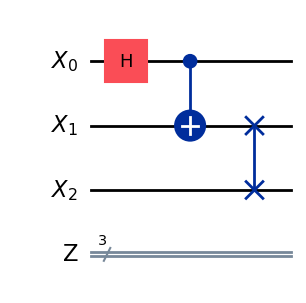

In [ ]:
m = 3
n = 0
control = QuantumRegister(m, "X")
target = QuantumRegister(n, "Y")
output = ClassicalRegister(m, "Z")

qc_orig = QuantumCircuit(control, target, output)
qc_orig.h(0)
qc_orig.cx(0,1)
qc_orig.swap(1,2)

#qc.measure_all()
display(qc_orig.draw(output = "mpl"))

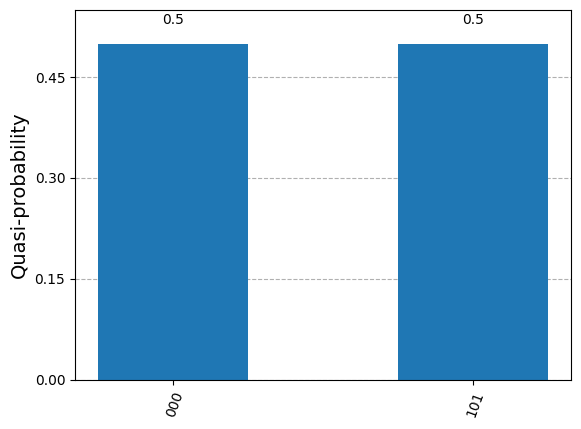

In [ ]:
ideal_distribution = Statevector.from_instruction(qc_orig).probabilities_dict()

plot_histogram(ideal_distribution)

## Noisy circuit simulation

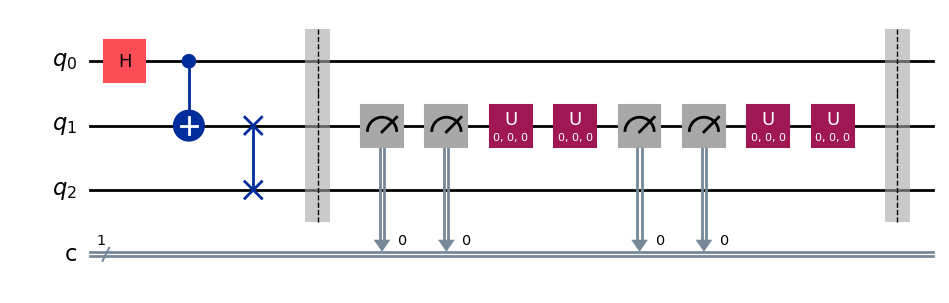

In [ ]:
# Noisy circuit simulation
# local measurements, r times
qbits = QuantumRegister(3, "q")
cbits = ClassicalRegister(1, "c")
qc = QuantumCircuit(qbits, cbits)
qc.h(0)
qc.cx(0, 1)
qc.swap(1, 2)

def single_rotations(theta, phi, lam, N):
    ug = UGate(theta, phi, lam, 1)
    return ug

# function for applyign DD sequences
#qc.u(0, 0, 0, 1)
#print(single_rotations(0, 0, 0, 1))
qc.barrier()

def pulse_sequence(N, r, theta, phi, lam):
    #R_x = u(theta, phi, lam, 1)
    [qc.measure(1, cbits) for _ in range(N//2)]
    [qc.u(theta, phi, lam, 1) for _ in range(r) ]
    [qc.measure(1, cbits) for _ in range(N//2)]
    [qc.u(-theta, -phi, -lam, 1) for _ in range(r) ]

#qc.to_gate(pulse_sequence(4, 2, 0, 0, 0))

pulse_sequence(4, 2, 0, 0, 0)
qc.barrier()
#qc.measure_all()

display(qc.draw("mpl"))

### Step 2 : Transpile the circuit

In [ ]:
# Circuit Optimization using a Simulator for an ibm backend
service = QiskitRuntimeService(channel="ibm_quantum", token="590ea288beb4c8f9055594d5b7bb76bf94f402aa79a3b8fbbbb7f3600e586da440f3bce4e7a8bbdc18e8bcfe01e6dac14a1e871e436c2ffb6531ee38053c26c5")
real_backend = service.backend("ibm_brisbane")
sim_backend = AerSimulator.from_backend(real_backend,seed_simulator=42)

sim_pm = generate_preset_pass_manager(
        backend=sim_backend,
        optimization_level=3,
        layout_method = "sabre",
        seed_transpiler = 42
)

C:\Users\PrakrishtPrakrisht\AppData\Local\Temp\ipykernel_36548\4053652480.py:2: DeprecationWarning: The "ibm_quantum" channel option is deprecated and will be sunset on 1 July. After this date, "ibm_cloud", "ibm_quantum_platform", and "local" will be the only valid channels. Open Plan users should migrate now.  All other users should review the migration guide (https://quantum.cloud.ibm.com/docs/migration-guides/classic-iqp-to-cloud-iqp)to learn when to migrate.
  service = QiskitRuntimeService(channel="ibm_quantum", token="590ea288beb4c8f9055594d5b7bb76bf94f402aa79a3b8fbbbb7f3600e586da440f3bce4e7a8bbdc18e8bcfe01e6dac14a1e871e436c2ffb6531ee38053c26c5")


### Dynamic Decoupling using CPMG Pulse sequences, i.e. even no. of pauli X pulses


In [ ]:

target = real_backend.target

#durations for each gate, error
durations = target.durations()

# from configuration , open_pulse
coupling_map = real_backend.configuration().coupling_map
basis_gates = real_backend.configuration().basis_gates
n_qubits = real_backend.configuration().n_qubits
dt = real_backend.configuration().dt
timing_constraints = real_backend.configuration().timing_constraints

# properties : T1, T2, Readout, gate errors,

durations_gen = InstructionDurations(
    [("h", None, 40), ("cx", None, 200), ("reset", None, 10),
     ("x", None, 40), ("u", None, 60), ("swap", None, 400),
     ("measure", None, 1000), ("measure", 1, 200)],
     dt = 1e-7
)

#schedule_map = real_backend.defaults().instruction_schedule_map
# Uhrig sequence on qubit 0
n = 8
dd_sequence = [XGate()] * n
def uhrig_pulse_location(k):
    return np.sin(np.pi * (k + 1) / (2 * n + 2)) ** 2
spacing = []
for k in range(n):
    spacing.append(uhrig_pulse_location(k) - sum(spacing))
spacing.append(1 - sum(spacing))

# this step we're just modifying the scheduling stage of the transpilation step
pm = PassManager([ALAPScheduleAnalysis(durations_gen), # identifies the idel durations pulse_alignment= timing_constraints,
                  PadDynamicalDecoupling(durations_gen, dd_sequence, spacing = spacing)])
circ_dd = pm.run(qc)


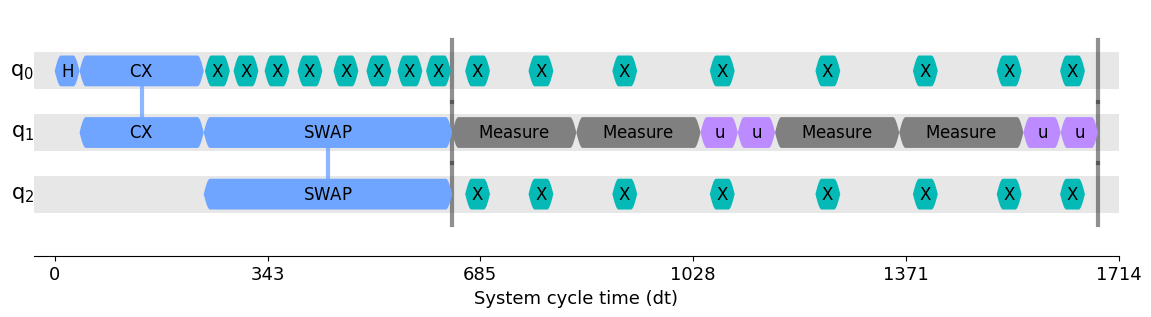

In [ ]:
timeline_drawer(circ_dd, target=target)

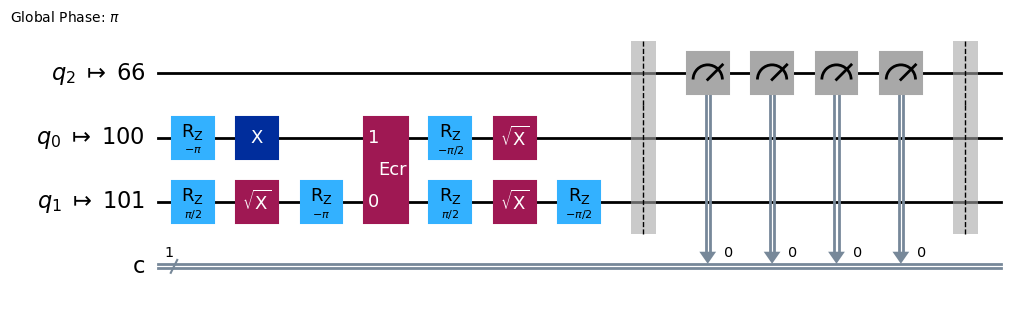

In [ ]:
isa_circuit = sim_pm.run(qc)

display(isa_circuit.draw("mpl", idle_wires= False))
#timeline_drawer(isa_circuit, target=target)

#### Step 3: Defining the LDD Sequence 
Here, we define the custom LDD sequence using parameters as discussed in the paper.

In [ ]:
from qiskit import pulse 
from qiskit.pulse  import *
from qiskit_ibm_runtime.fake_provider import *

def LDD_sequence(tau, theta, phi, lam, dt, qbit, r):
    duration = int(160)
    amp = 0.2
    sigma = duration/10

    with pulse.build(name = "LDD") as ldd_seq:
        d0 = pulse.DriveChannel(qbit)
        for i in range(r):
            pulse.delay(tau, d0)
            pulse.shift_phase(theta, d0) #z
            pulse.play(pulse.Gaussian(duration, amp, sigma), d0) #y
            pulse.shift_phase(lam, d0) #z
            pulse.delay(tau, d0)
            pulse.shift_phase(-theta, d0) #z
            pulse.play(pulse.Gaussian(duration, amp, sigma), d0) #y
            pulse.shift_phase(-lam, d0) #z
        #pulse.delay(tau, d0)
        #ldd_seq.draw()

    return ldd_seq


C:\Users\PrakrishtPrakrisht\AppData\Local\Temp\ipykernel_36548\4209927461.py:10: DeprecationWarning: The function ``qiskit.pulse.builder.build()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  with pulse.build(name = "LDD") as ldd_seq:
C:\Users\PrakrishtPrakrisht\AppData\Local\Temp\ipykernel_36548\4209927461.py:11: DeprecationWarning: The class ``qiskit.pulse.channels.Channel`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  d0 = pulse.DriveChannel(qbit)
C:\Users\PrakrishtPrakrisht\AppData\Local\Temp\ipykernel_36548\4209927461.py:13: DeprecationWarning: The function ``qiskit.pulse.builder.delay()`` is deprecated as of Qiskit 1.3. It wil

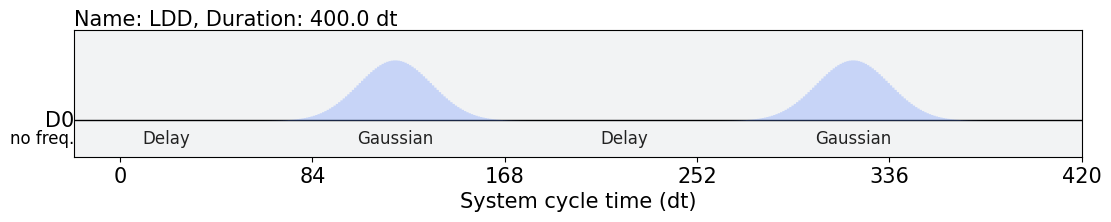

In [ ]:
schedule = LDD_sequence(40, 0, 0, 0, 1e-9, 0, 1)
schedule.draw()

Then, we convert the LDD sequence into a gate representation that can be used in the circuit.

C:\Users\PrakrishtPrakrisht\AppData\Local\Temp\ipykernel_36548\777241008.py:13: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.add_calibration()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics. Note that once removed, ``qiskit.circuit.quantumcircuit.QuantumCircuit.add_calibration()`` will have no alternative in Qiskit.
  qc_orig.add_calibration(custom_gate, [0], schedule)


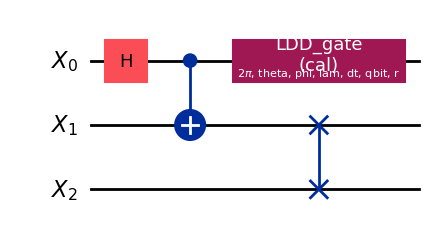

In [ ]:
### Convert it to a gate 
from qiskit.circuit import Gate, Parameter
theta = Parameter('theta')
phi = Parameter('phi')
lam = Parameter('lam')
qbit = Parameter('qbit')
r = Parameter('r')
dt = Parameter('dt')

#qc.measure_all()
custom_gate = Gate(name = "LDD_gate", num_qubits= 1, params=[tau, theta, phi, lam, dt, qbit, r])
qc_orig.append(custom_gate, [0])
qc_orig.add_calibration(custom_gate, [0], schedule)

display(qc_orig.draw("mpl", idle_wires= False))


Now we're trying to optimize the circuit using the same simulated backend, but with a different pass manager to identify the idel times as well, where the LDD pulses should be applied

In [ ]:

isa_circuit2 = transpile(qc_orig, backend=sim_backend, scheduling_method='alap', optimization_level=3)

from qiskit.pulse.channels import DriveChannel

d0 = DriveChannel(0)
insts = schedule.filter(channels=[d0]).instructions

# Find idle periods on DriveChannel(0)
idle_slots = []
current_time = 0

for (t, inst) in insts:
    if t > current_time:
        idle_slots.append((current_time, t))  # An idle gap
    current_time = max(current_time, t + inst.duration)

print(idle_slots)


The code fails, since the Transpiler fails to synthesize the instruction, because the High Level Synethesis in Qiskit only works with well defined values of parameters, not free parameters, which is yet to be implemented. 

###  Step 4: Define Optimization Sequence

We define an Optimization function that uses Simultaneous perturbation stochastic approximation (SPSA) Algoithm to minimise the value of the loss function, which in turn gives us the optimized parameters for:

$$ R = e^{\frac{-i\theta}{2}Z} e^{\frac{-i\phi}{2}Y}e^{\frac{-i\lambda}{2}Z}$$



In [ ]:
from qiskit_algorithms.optimizers import SPSA
from qiskit.circuit.library import PauliTwoDesign
from qiskit_ibm_runtime import QiskitRuntimeService, EstimatorV2 as Estimator
from qiskit.quantum_info import SparsePauliOp

service = QiskitRuntimeService(channel="ibm_quantum", token= "590ea288beb4c8f9055594d5b7bb76bf94f402aa79a3b8fbbbb7f3600e586da440f3bce4e7a8bbdc18e8bcfe01e6dac14a1e871e436c2ffb6531ee38053c26c5")
real_backend = service.backend("ibm_brisbane")

transpiled_circuit = transpile(qc, real_backend)
pauli_list = [("III", 1), ("IXX", 1), ("XIX", 1), ("XXI", 1), ("IYY", -1),("YIY", -1),("YYI", -1), ("IZZ", 1), ("ZIZ", 1), ("ZZI", 1)]
op = SparsePauliOp.from_list(pauli_list)
cost_function = op.apply_layout(transpiled_circuit.layout)
initial_point = np.random.random(transpiled_circuit.num_parameters)


estimator = Estimator(mode=real_backend)   #IBM backend

def loss(x):
    job = estimator.run([(transpiled_circuit, cost_function,[x])])
    #print(job.result())
    return job.result()[0].data.evs

spsa =  SPSA(maxiter=3)

result = spsa.minimize(loss, x0=initial_point)

print(result.x)

C:\Users\PrakrishtPrakrisht\AppData\Local\Temp\ipykernel_36548\89550299.py:6: DeprecationWarning: The "ibm_quantum" channel option is deprecated and will be sunset on 1 July. After this date, "ibm_cloud", "ibm_quantum_platform", and "local" will be the only valid channels. Open Plan users should migrate now.  All other users should review the migration guide (https://quantum.cloud.ibm.com/docs/migration-guides/classic-iqp-to-cloud-iqp)to learn when to migrate.
  service = QiskitRuntimeService(channel="ibm_quantum", token= "590ea288beb4c8f9055594d5b7bb76bf94f402aa79a3b8fbbbb7f3600e586da440f3bce4e7a8bbdc18e8bcfe01e6dac14a1e871e436c2ffb6531ee38053c26c5")
qiskit_runtime_service.check_pending_jobs:WARNING:2025-06-25 13:38:47,865: The pending jobs limit has been reached. Waiting for job <RuntimeJobV2('d1dxbs75z6q0008pvv1g', 'estimator')> to finish before submitting the next one.


IBMRuntimeError: 'Failed to run program: \'409 Client Error: Conflict for url: https://api.quantum.ibm.com/runtime/jobs. {"errors":[{"message":"You have reached the limit of 3 pending  jobs. Please wait for a job to complete or cancel one before submitting anything new.","code":3458,"solution":"Wait until some previous jobs were finished. You can cancel pending jobs to run new jobs.","more_info":"https://docs.quantum-computing.ibm.com/errors"}]}\''

## Results: Fidelity vs Iteration Plots, Benchmarking with Naive

## Conclusion
We implemeneted a proof-of-concept for Learning Dynamical Decoupling (LDD) that adapts to specific quantum circuit and hardware. This method, employs a closed loop circuit to iterate through and optimize the parameters of the Dynamical Decoupling sequence, which in turn optimizes the fidelity of the circuit using the SPSA algorithm to mitigate decoherence errors.